In [71]:
import numpy as np
import numpy.typing as npt
from typing import List, Tuple
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [ ]:
def BSMPathExtended(
    S_0: float, 
    r: float, 
    sigma: float, 
    T: float, 
    N: int, 
    rng: np.random.Generator,
    extension_steps: int
):
    delta = T / N
    Z = rng.normal(loc=0, scale=1, size=(N + extension_steps))
    path = np.empty((N + extension_steps + 1), dtype=np.float64)
    path[0] = S_0
    for i in range(N + extension_steps):
        path[i + 1] = path[i] * np.exp((r - 0.5 * np.power(sigma, 2.0)) * delta + sigma * np.sqrt(delta) * Z[i])
    return path

def MeanRevertingPathFollower(
    underlying_path: npt.NDArray,
    reversion_strength: float,
    volatility: float,
    T: float, 
    N: int, 
    rng: np.random.Generator,
    forward_shift: int
):
    dt = T / N
    Z = rng.normal(loc=0, scale=1, size=(N))
    path = np.zeros(shape=(N))
    length = path.shape[0]
    
    path[0] = underlying_path[0]
    for idx in range(1, length):
        dP = (
            reversion_strength * (underlying_path[idx - 1 + forward_shift] - path[idx - 1]) * dt + 
            volatility * np.sqrt(dt * path[idx - 1]) * Z[idx - 1]
        )
        path[idx] = abs(path[idx - 1] + dP)
    return path

def sliding_window_edge_pad(arr: npt.NDArray, window_size: int):
    pad_width = window_size // 2
    arr_padded = np.pad(arr, pad_width=pad_width, mode='edge')
    window = np.ones(window_size) / window_size
    result = np.convolve(arr_padded, window, mode='valid')
    return result

In [73]:
S_0 = 0.1
T = 1.0
N = 1000
r = 0.0
sigma = 0.25

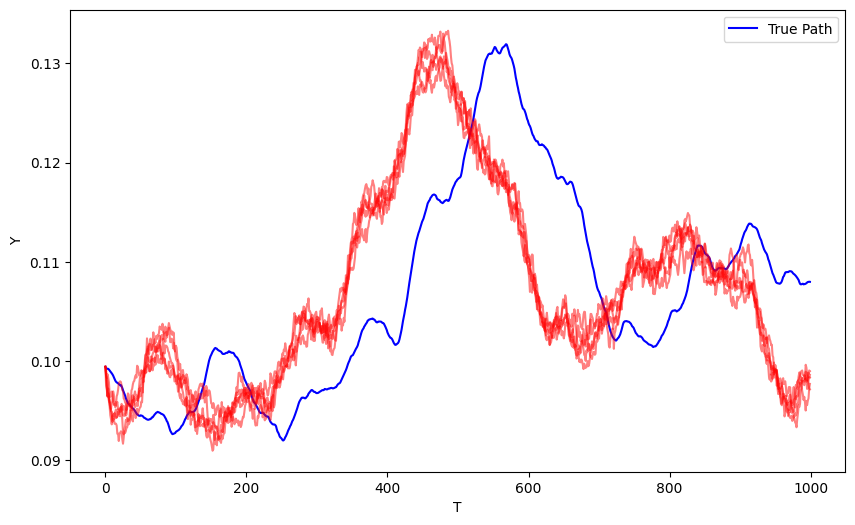

In [123]:
rng = np.random.default_rng()
agent_count = 5
agent_analyst_error: dict[int, float] = {}
agent_analyst_error_std = 0.0025
forecast_error_std = 0.0005
forecast_horizon = 100
path = sliding_window_edge_pad(BSMPathExtended(S_0, r, sigma, T, N, rng, forecast_horizon), 21)

for agent_id in range(agent_count):
    agent_analyst_error[agent_id] = rng.normal(0, agent_analyst_error_std)
    pass

plt.figure(figsize=(10, 6))
plt.plot(path[:N], color="blue", label="True Path")

for agent_id in range(agent_count):
    agent_path = MeanRevertingPathFollower(path, 100, 0.05, T, N, rng, forecast_horizon)
    plt.plot(agent_path, alpha=0.5, color="red")
    
    # agent_path = path[forecast_horizon:N+forecast_horizon+1] + rng.normal(agent_analyst_error[agent_id], forecast_error_std, size=(N + 1))
    # plt.plot(agent_path, alpha=0.5, color="green")
    pass
        
plt.xlabel("T")
plt.ylabel("Y")
plt.legend()
plt.show()